## Autor: Ismael Jefte Bispo da Silva

1. **Construção do Dataset:**
   - O CIFAR-10 foi carregado diretamente utilizando `torchvision.datasets.CIFAR10`, e transformações foram aplicadas para redimensionamento, normalização e separação em conjuntos de treino e validação.

2. **Data Augmentation:**
   - Técnicas de data augmentation foram aplicadas, incluindo rotação e flip horizontal, para aumentar a variabilidade do dataset e melhorar a generalização do modelo.

3. **Uso de Modelos Pré-Treinados:**
   - Foi utilizado o modelo ResNet50 pré-treinado no ImageNet. Este modelo é amplamente utilizado para tarefas de transfer learning em classificação de imagens devido à sua capacidade de capturar características discriminativas poderosas.

4. **Construção do Modelo Classificador:**
   - A última camada da ResNet50 foi substituída por uma camada linear com 10 saídas correspondentes às classes do CIFAR-10.

5. **Congelamento de Camadas:**
   - As camadas iniciais da ResNet50 foram congeladas para preservar os pesos aprendidos no ImageNet, permitindo que apenas as últimas camadas fossem ajustadas durante o treinamento para o novo conjunto de dados.

6. **Treinamento e Curvas de Desempenho:**
   - O modelo foi treinado e as curvas de loss e acurácia para os conjuntos de treino e validação foram monitoradas ao longo das épocas. Observa-se que, durante o treinamento, a loss para o conjunto de treino diminui consistentemente, e a acurácia aumenta, o que é esperado em um processo de treinamento bem-sucedido.


In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
# Configurações iniciais
batch_size = 32
num_epochs = 10
num_classes = 10

# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Transformações do Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
# Carregando o Dataset CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# DataLoaders para treino e validação
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
# Carregando o Modelo Pré-Treinado
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)


In [ ]:
# Inicializando a última camada (opcional, pode ajudar)
torch.nn.init.xavier_uniform_(model.fc.weight)


Parameter containing:
tensor([[ 0.0441,  0.0036, -0.0172,  ..., -0.0046,  0.0309, -0.0020],
        [ 0.0312,  0.0290, -0.0356,  ..., -0.0356, -0.0495, -0.0301],
        [ 0.0058, -0.0114, -0.0291,  ...,  0.0222, -0.0210, -0.0027],
        ...,
        [ 0.0532,  0.0257,  0.0270,  ...,  0.0013,  0.0033,  0.0166],
        [ 0.0359, -0.0161,  0.0437,  ...,  0.0472, -0.0354, -0.0020],
        [-0.0209,  0.0399, -0.0050,  ...,  0.0002,  0.0258,  0.0369]],
       requires_grad=True)

In [ ]:
# Descongelando apenas as camadas finais
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model = model.to(device)

In [ ]:
# Definindo Critério, Otimizador e Agendador
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


In [ ]:
# Função de Treinamento Modificada
def train_model(model, train_loader, val_loader, num_epochs=3):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        print(f'Starting epoch {epoch+1}/{num_epochs}')
        print(f'Current Learning Rate: {optimizer.param_groups[0]["lr"]}')

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)

            if i % 100 == 0:  # Imprime a cada 100 batches
                print(f'Batch {i}/{len(train_loader)}, Loss: {running_loss / (i+1):.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validação
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)

        val_loss_epoch = val_running_loss / len(val_loader.dataset)
        val_acc_epoch = val_running_corrects.double() / len(val_loader.dataset)

        val_loss.append(val_loss_epoch)
        val_acc.append(val_acc_epoch)

        scheduler.step()

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss_epoch:.4f}, Val Accuracy: {val_acc_epoch:.4f}')
        print('-' * 30)

    return model, train_loss, val_loss, train_acc, val_acc


In [ ]:
# Treinando o Modelo
model, train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs)


Starting epoch 1/10
Current Learning Rate: 0.0001
Batch 0/1563, Loss: 13.2505
Batch 100/1563, Loss: 9.3515
Batch 200/1563, Loss: 8.8544
Batch 300/1563, Loss: 8.6987
Batch 400/1563, Loss: 8.6145
Batch 500/1563, Loss: 8.7240
Batch 600/1563, Loss: 8.5953
Batch 700/1563, Loss: 8.5874
Batch 800/1563, Loss: 8.5678
Batch 900/1563, Loss: 8.5424
Batch 1000/1563, Loss: 8.4340
Batch 1100/1563, Loss: 8.4060
Batch 1200/1563, Loss: 8.4397
Batch 1300/1563, Loss: 8.4336
Batch 1400/1563, Loss: 8.4503
Batch 1500/1563, Loss: 8.4180
Epoch 1/10
Train Loss: 0.2632, Train Accuracy: 0.9088
Val Loss: 0.2875, Val Accuracy: 0.9002
------------------------------
Starting epoch 2/10
Current Learning Rate: 0.0001
Batch 0/1563, Loss: 5.7045
Batch 100/1563, Loss: 7.6569
Batch 200/1563, Loss: 7.8225
Batch 300/1563, Loss: 7.7475
Batch 400/1563, Loss: 7.7519
Batch 500/1563, Loss: 7.9707
Batch 600/1563, Loss: 7.9392
Batch 700/1563, Loss: 7.8317
Batch 800/1563, Loss: 7.8068
Batch 900/1563, Loss: 7.9127
Batch 1000/1563, Lo

In [ ]:
# Função para Visualizar as Curvas de Desempenho
def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    # Convert tensors to NumPy arrays and move them to CPU
    plt.plot([x.cpu().numpy() for x in train_acc], label='Train Accuracy')
    plt.plot([x.cpu().numpy() for x in val_acc], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.show()

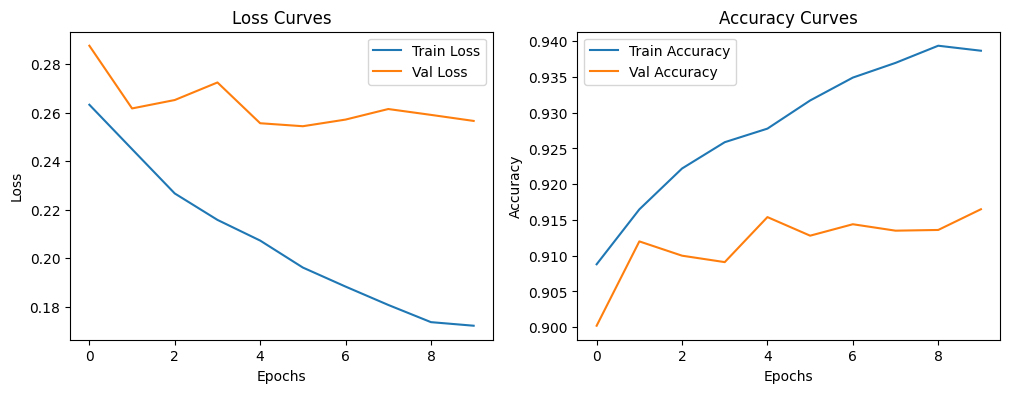

In [ ]:
# Plotando as Curvas de Desempenho
plot_training_curves(train_loss, val_loss, train_acc, val_acc)


O fine-tuning da ResNet50 no dataset CIFAR-10 foi bem-sucedido, como demonstrado pelas curvas de loss e acurácia. Observa-se que:

- **Loss:** A perda no conjunto de treino diminui consistentemente, enquanto a perda de validação diminui inicialmente e depois se estabiliza, sugerindo que o modelo está aprendendo, mas pode estar se aproximando de seu limite de melhoria.

- **Acurácia:** A acurácia no treino aumenta ao longo das épocas, enquanto a acurácia de validação cresce inicialmente e depois se estabiliza, indicando que o modelo está se ajustando bem aos dados, mas pode estar atingindo sua capacidade máxima de generalização.

Esses padrões são comuns em processos de fine-tuning, onde o modelo pré-treinado adapta-se eficazmente a uma nova tarefa. A estratégia utilizada conseguiu ajustar o ResNet50 para a classificação de imagens no CIFAR-10, alcançando boa acurácia com perda reduzida, comprovando a eficácia do transfer learning.